In [7]:
# Import required libraries
import pandas as pd
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow import keras

In [2]:
# Load the dataset
df = pd.read_csv('../dataset/set_01_new.csv', encoding='utf-8').dropna()
df.columns = ['label', 'data']

X = df['data']
y = df['label']

In [3]:
# Split the dataset into training and validating sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.66, random_state=7)

# Feature extration
vectorizer = HashingVectorizer(stop_words='english', n_features=5000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_val = vectorizer.transform(X_val).toarray()
X_test = vectorizer.transform(X_test).toarray()

X_train.shape[1]

5000

In [7]:
# Build the Neural Network model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                320064    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 320,129
Trainable params: 320,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
56/56 [==============================] - 2s 17ms/step - loss: 0.5954 - accuracy: 0.8480 - val_loss: 0.4717 - val_accuracy: 0.8935
Epoch 2/20
56/56 [==============================] - 0s 6ms/step - loss: 0.3503 - accuracy: 0.9359 - val_loss: 0.2653 - val_accuracy: 0.9671
Epoch 3/20
56/56 [==============================] - 0s 6ms/step - loss: 0.1832 - accuracy: 0.9836 - val_loss: 0.1619 - val_accuracy: 0.9764
Epoch 4/20
56/56 [=====

In [20]:
# Helper function to compile and train the model with given param
def train_model(learning_rate, hidden_layer_size, optimizer, epochs):
    model = Sequential()
    model.add(Dense(units=hidden_layer_size, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val))
    return model, history

In [25]:
class ModelBlueprint:
    def __init__(self, learning_rate, hidden_layer_size, optimizer, epochs):
        self.learning_rate = learning_rate
        self.hidden_layer_size = hidden_layer_size
        self.optimizer = optimizer
        self.epochs = epochs

# Define a list of models
modelBlueprints = []
modelBlueprints.append(ModelBlueprint(0.0001, 64, keras.optimizers.Adam, 10))
modelBlueprints.append(ModelBlueprint(0.001, 64, keras.optimizers.Adam, 10))
modelBlueprints.append(ModelBlueprint(0.01, 64, keras.optimizers.Adam, 10))
modelBlueprints.append(ModelBlueprint(0.0001, 64, keras.optimizers.RMSprop, 10))
modelBlueprints.append(ModelBlueprint(0.001, 64, keras.optimizers.RMSprop, 10))
modelBlueprints.append(ModelBlueprint(0.01, 64, keras.optimizers.RMSprop, 10))
modelBlueprints.append(ModelBlueprint(0.0001, 128, keras.optimizers.Adam, 10))
modelBlueprints.append(ModelBlueprint(0.001, 128, keras.optimizers.Adam, 10))
modelBlueprints.append(ModelBlueprint(0.01, 128, keras.optimizers.Adam, 10))
modelBlueprints.append(ModelBlueprint(0.0001, 128, keras.optimizers.RMSprop, 10))
modelBlueprints.append(ModelBlueprint(0.001, 128, keras.optimizers.RMSprop, 10))
modelBlueprints.append(ModelBlueprint(0.01, 128, keras.optimizers.RMSprop, 10))

# Run each models and get the best validation accuracy
models = []
histories = []
for blueprint in modelBlueprints:
    model, history = train_model(blueprint.learning_rate, blueprint.hidden_layer_size, blueprint.optimizer, blueprint.epochs)
    models.append(model)
    histories.append(history)

for model in models:
    best_val_acc = max(model.history.history['val_accuracy'])
    best_val_acc_index = model.history.history['val_accuracy'].index(best_val_acc)
    print(f'Best Val accuracy: {best_val_acc} at epoch {best_val_acc_index}')

Epoch 1/10
56/56 [==============================] - 1s 8ms/step - loss: 0.6795 - accuracy: 0.8264 - val_loss: 0.6689 - val_accuracy: 0.8628
Epoch 2/10
56/56 [==============================] - 0s 6ms/step - loss: 0.6566 - accuracy: 0.8582 - val_loss: 0.6456 - val_accuracy: 0.8628
Epoch 3/10
56/56 [==============================] - 0s 6ms/step - loss: 0.6297 - accuracy: 0.8576 - val_loss: 0.6180 - val_accuracy: 0.8628
Epoch 4/10
56/56 [==============================] - 0s 6ms/step - loss: 0.5992 - accuracy: 0.8576 - val_loss: 0.5879 - val_accuracy: 0.8635
Epoch 5/10
56/56 [==============================] - 0s 6ms/step - loss: 0.5668 - accuracy: 0.8593 - val_loss: 0.5570 - val_accuracy: 0.8678
Epoch 6/10
56/56 [==============================] - 0s 6ms/step - loss: 0.5339 - accuracy: 0.8661 - val_loss: 0.5262 - val_accuracy: 0.8706
Epoch 7/10
56/56 [==============================] - 0s 6ms/step - loss: 0.5018 - accuracy: 0.8701 - val_loss: 0.4963 - val_accuracy: 0.8728
Epoch 8/10
56/56 [==

In [29]:
# Get the best model based on validation accuracy
best_val_accuracy_overall = 0
best_model = ''
best_history = ''


for i, history in enumerate(histories):
    best_val_acc = max(history.history['val_accuracy'])
    if(best_val_acc > best_val_accuracy_overall):
        best_val_accuracy_overall = best_val_acc
        best_model = models[i]
        best_history = history

print(best_model.optimizer.get_config())
print(best_model.summary())

{'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 64)                320064    
                                                                 
 dense_79 (Dense)            (None, 1)                 65        
                                                                 
Total params: 320,129
Trainable params: 320,129
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
import matplotlib.pyplot as plt

# Helper function for plot graph
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.figure()

85/85 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.9775
Test accuracy: 0.9775404930114746


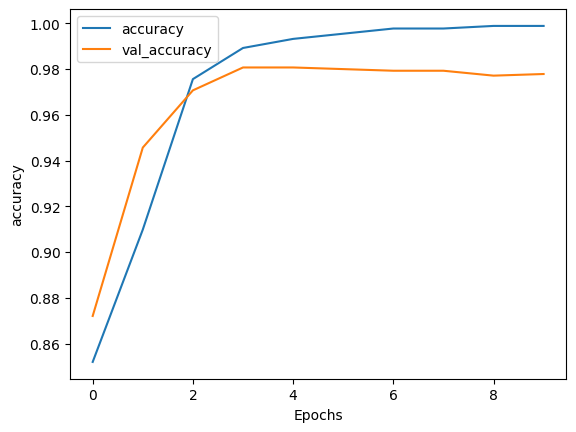

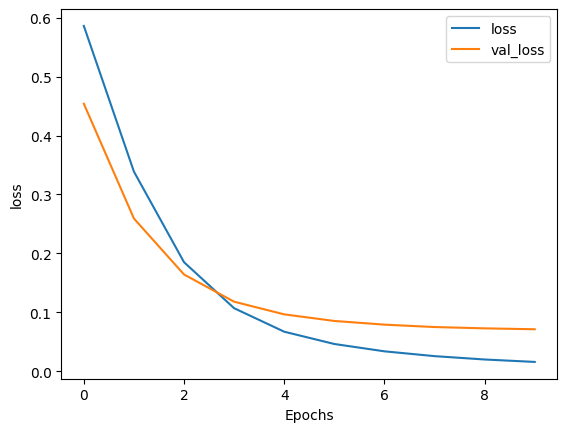

<Figure size 640x480 with 0 Axes>

In [30]:
# Evaluate the model on the testing set
loss, accuracy = best_model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

plot_graphs(best_history, 'accuracy')
plot_graphs(best_history, 'loss')

In [31]:
# Test the performance of the model
def spamDetection(message):
    vectorizer = HashingVectorizer(stop_words='english', n_features=5000)
    inputMsg = vectorizer.fit_transform([message]).toarray()
    return best_model.predict(inputMsg)

print(spamDetection("hey let grab lunch tgt next week shall we"))
print(spamDetection("important email account has been hacked attention require click link to reset password"))

1/1 [==============================] - 1s 1s/step
[[0.00272815]]
1/1 [==============================] - 0s 30ms/step
[[0.10677119]]
